In [19]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== DATA LOADING ====================
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    Returns:
        tuple: (X_scaled, df) - scaled feature matrix and original dataframe
    """
    # Load data with semicolon separator
    df = pd.read_csv(filepath, sep=';')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X = df[features]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df


# ==================== PCA DIMENSIONALITY REDUCTION ====================
def apply_pca(x, n_components):
    """Apply PCA for dimensionality reduction.

    Args:
        x: Input data matrix
        n_components: Number of principal components to keep

    Returns:
        numpy.ndarray: Transformed data with reduced dimensions
    """
    # Initialize and fit PCA
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)

    # Print explained variance information
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Explained variance by component
    axes[0].bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('Explained Variance by Component')
    axes[0].set_xticks(range(1, n_components + 1))
    for i, v in enumerate(pca.explained_variance_ratio_):
        axes[0].text(i + 1, v + 0.01, f'{v:.3f}', ha='center')

    # Plot 2: Data distribution in PCA space (2D)
    if n_components >= 2:
        axes[1].scatter(x_pca[:, 0], x_pca[:, 1], alpha=0.5, s=10)
        axes[1].set_xlabel('First Principal Component')
        axes[1].set_ylabel('Second Principal Component')
        axes[1].set_title('Data Distribution in PCA Space')

    plt.tight_layout()
    plt.show()

    return x_pca


# ==================== K-MEANS CLUSTERING ====================
def find_optimal_clusters(x, max_clusters=10):
    """Find optimal number of clusters using Elbow Method.

    Args:
        x: Input data matrix
        max_clusters: Maximum number of clusters to test

    Returns:
        tuple: (inertias, silhouette_scores) - lists of metrics for each k
    """
    from sklearn.cluster import KMeans

    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)

    print("Finding optimal clusters...")
    for k in K_range:
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(x)

        # Calculate metrics
        inertias.append(kmeans.inertia_)
        silhouette = silhouette_score(x, kmeans.labels_)
        silhouette_scores.append(silhouette)

        print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.4f}")

    # Plot elbow curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Inertia plot
    axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
    axes[0].set_title('Elbow Method: Inertia vs Number of Clusters')
    axes[0].grid(True, alpha=0.3)

    # Silhouette score plot
    axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score vs Number of Clusters')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return inertias, silhouette_scores


def perform_kmeans_clustering(x, n_clusters=None):
    """Perform KMeans clustering.

    Args:
        x: Input data matrix
        n_clusters: Number of clusters (if None, defaults to 3)

    Returns:
        sklearn.cluster.KMeans: Fitted KMeans model
    """
    from sklearn.cluster import KMeans

    if n_clusters is None:
        n_clusters = 3
        print("Warning: n_clusters not specified, using default value of 3")

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(x)

    # Calculate and print metrics
    silhouette = silhouette_score(x, kmeans.labels_)
    print(f"\nKMeans Clustering Results (k={n_clusters}):")
    print(f"Inertia: {kmeans.inertia_:.2f}")
    print(f"Silhouette Score: {silhouette:.4f}")

    # Visualize results
    if x.shape[1] == 2:  # If 2D data, create visualization
        from sklearn.metrics import silhouette_samples

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Scatter plot with centroids
        scatter = axes[0].scatter(x[:, 0], x[:, 1], c=kmeans.labels_,
                                 cmap='viridis', alpha=0.6, s=10)
        axes[0].scatter(kmeans.cluster_centers_[:, 0],
                       kmeans.cluster_centers_[:, 1],
                       c='red', marker='x', s=200, linewidths=3,
                       label='Centroids')
        axes[0].set_xlabel('First Principal Component')
        axes[0].set_ylabel('Second Principal Component')
        axes[0].set_title('K-means Clustering Results with Centroids')
        axes[0].legend()
        plt.colorbar(scatter, ax=axes[0])

        # Plot 2: Cluster sizes
        unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
        axes[1].bar(unique_labels, counts, color='skyblue', edgecolor='black')
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel('Number of Samples')
        axes[1].set_title('K-means Cluster Sizes')
        axes[1].set_xticks(unique_labels)
        for i, v in enumerate(counts):
            axes[1].text(i, v + 50, str(v), ha='center', va='bottom')

        # Plot 3: Silhouette distribution per cluster
        silhouette_vals = silhouette_samples(x, kmeans.labels_)
        cluster_silhouette_data = [silhouette_vals[kmeans.labels_ == i]
                                  for i in unique_labels]
        axes[2].boxplot(cluster_silhouette_data, labels=unique_labels)
        axes[2].set_xlabel('Cluster')
        axes[2].set_ylabel('Silhouette Score')
        axes[2].set_title('Silhouette Score Distribution per Cluster')
        axes[2].axhline(y=silhouette, color='r', linestyle='--',
                       label=f'Mean: {silhouette:.3f}')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return kmeans


# ==================== AGGLOMERATIVE CLUSTERING ====================
def perform_agglomerative_clustering(x, n_clusters=None):
    """Perform Agglomerative (Hierarchical) clustering.

    Args:
        x: Input data matrix
        n_clusters: Number of clusters (if None, defaults to 3)

    Returns:
        sklearn.cluster.AgglomerativeClustering: Fitted model
    """
    if n_clusters is None:
        n_clusters = 3
        print("Warning: n_clusters not specified, using default value of 3")

    # Initialize and fit Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters,
                                             linkage='ward')
    labels = agg_clustering.fit_predict(x)

    # Calculate metrics
    silhouette = silhouette_score(x, labels)
    print(f"\nAgglomerative Clustering Results (k={n_clusters}):")
    print(f"Silhouette Score: {silhouette:.4f}")

    # Visualize results if 2D data
    if x.shape[1] == 2:
        from sklearn.metrics import silhouette_samples

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Scatter plot
        scatter = axes[0].scatter(x[:, 0], x[:, 1], c=labels,
                                 cmap='viridis', alpha=0.6, s=10)
        axes[0].set_xlabel('First Principal Component')
        axes[0].set_ylabel('Second Principal Component')
        axes[0].set_title('Agglomerative Clustering Results')
        plt.colorbar(scatter, ax=axes[0])

        # Plot 2: Cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        axes[1].bar(unique_labels, counts, color='lightcoral', edgecolor='black')
        axes[1].set_xlabel('Cluster')
        axes[1].set_ylabel('Number of Samples')
        axes[1].set_title('Agglomerative Cluster Sizes')
        axes[1].set_xticks(unique_labels)
        for i, v in enumerate(counts):
            axes[1].text(i, v + 50, str(v), ha='center', va='bottom')

        # Plot 3: Silhouette distribution
        silhouette_vals = silhouette_samples(x, labels)
        cluster_silhouette_data = [silhouette_vals[labels == i]
                                  for i in unique_labels]
        axes[2].boxplot(cluster_silhouette_data, labels=unique_labels)
        axes[2].set_xlabel('Cluster')
        axes[2].set_ylabel('Silhouette Score')
        axes[2].set_title('Silhouette Distribution per Cluster')
        axes[2].axhline(y=silhouette, color='r', linestyle='--',
                       label=f'Mean: {silhouette:.3f}')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return agg_clustering


# ==================== DENDROGRAM ====================
def get_linkages(x):
    """Calculate linkage matrix for hierarchical clustering.

    Args:
        x: Input data matrix

    Returns:
        numpy.ndarray: Linkage matrix
    """
    # Calculate linkage using Ward's method
    linked = linkage(x, method='ward')
    return linked


def plot_dendrogram(linked):
    """Plot dendrogram for hierarchical clustering.

    Args:
        linked: Linkage matrix from get_linkages()
    """
    plt.figure(figsize=(12, 6))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               no_labels=True)  # Set to False to show sample labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index (or Cluster Size)')
    plt.ylabel('Distance (Ward)')
    plt.axhline(y=500, color='r', linestyle='--', label='Potential cut line')
    plt.legend()
    plt.tight_layout()
    plt.show()




In [ ]:
# ==================== EXAMPLE USAGE ====================
if __name__ == "__main__":
    print("=" * 60)
    print("BANK CUSTOMER SEGMENTATION - FUNCTION DEMONSTRATION")
    print("=" * 60)

    # Load data
    print("\n1. Loading data...")
    X_scaled, data = load_data('bank-full.csv')
    print(f"Data shape: {X_scaled.shape}")

    # Apply PCA
    print("\n2. Applying PCA...")
    X_pca = apply_pca(X_scaled, n_components=2)

    # Find optimal clusters
    print("\n3. Finding optimal clusters...")
    inertias, silhouette_scores = find_optimal_clusters(X_pca, max_clusters=10)

    # Perform KMeans clustering
    print("\n4. Performing KMeans clustering...")
    kmeans = perform_kmeans_clustering(X_pca, n_clusters=3)

    # Perform Agglomerative clustering
    print("\n5. Performing Agglomerative clustering...")
    agg = perform_agglomerative_clustering(X_pca, n_clusters=3)

    # Generate and plot dendrogram
    print("\n6. Generating dendrogram...")
    linked = get_linkages(X_pca)
    plot_dendrogram(linked)

    print("\n" + "=" * 60)
    print("ALL FUNCTIONS COMPLETED SUCCESSFULLY")
    print("=" * 60)

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [21]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=";")   # ✔ Load bank-full.csv with correct separator

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']

    X = df[features]   # ✔ Select features

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)   # ✔ Apply StandardScaler

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')

print("Data shape:", X_scaled.shape)


Data shape: (45211, 9)


In [22]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit
    """

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids by randomly selecting points from X."""
        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        """Assign each sample to the nearest centroid."""
        # Compute distances: shape = (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
        # Closest centroid index
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as mean of assigned points."""
        new_centroids = []

        for cluster_id in range(self.n_clusters):
            cluster_points = X[labels == cluster_id]

            if len(cluster_points) == 0:
                # Empty cluster — reinitialize centroid randomly
                new_centroid = X[np.random.randint(0, len(X))]
            else:
                new_centroid = cluster_points.mean(axis=0)

            new_centroids.append(new_centroid)

        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence or max iterations."""
        # 1. Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # 2. Assign clusters
            labels = self._assign_clusters(X)

            # 3. Update centroids
            new_centroids = self._update_centroids(X, labels)

            # 4. Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        # Store final labels
        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using learned centroids."""
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

In [23]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # ---- 1. Explained Variance Ratio ----
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, color="skyblue")
    plt.title("Explained Variance Ratio")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")

    # ---- 2. Cumulative Explained Variance ----
    plt.subplot(1, 3, 2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.ylim(0, 1)

    # ---- 3. 2D PCA Scatter ----
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.5)
    plt.title("PCA Projection (2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca


## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

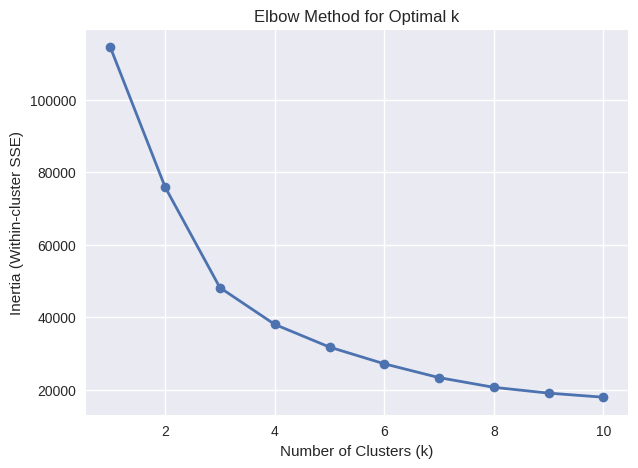

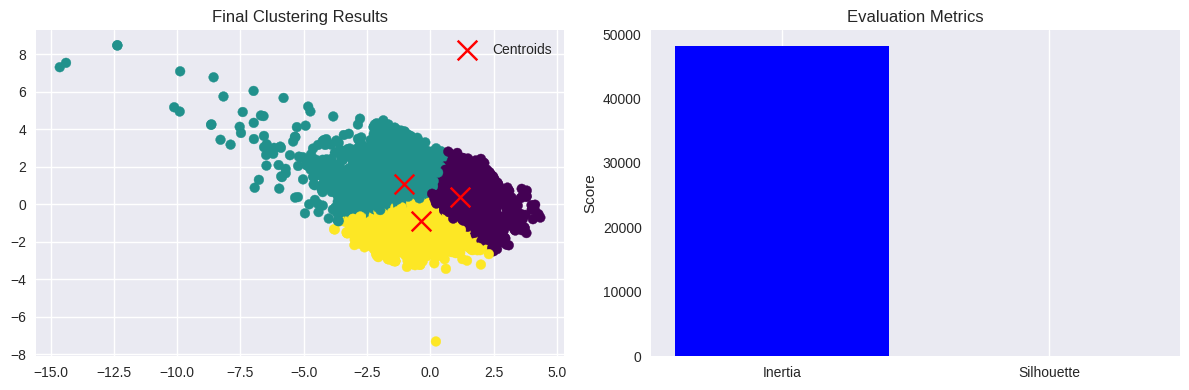


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [24]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0

    # Sum squared distances of each point to its assigned centroid
    for i in range(len(X)):
        centroid = centroids[labels[i]]
        inertia += np.sum((X[i] - centroid) ** 2)

    return inertia


def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters."""

    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        model = KMeansClustering(n_clusters=k)
        model.fit(X)

        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    # Plot elbow curve
    plt.figure(figsize=(7,5))
    plt.plot(K, inertias, 'o-', linewidth=2)
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Within-cluster SSE)")
    plt.grid(True)
    plt.show()

    return inertias


# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Change this based on elbow
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

plt.subplot(1, 2, 2)
plt.bar(["Inertia", "Silhouette"], [inertia, silhouette], color=['blue', 'green'])
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Final printed metrics
print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


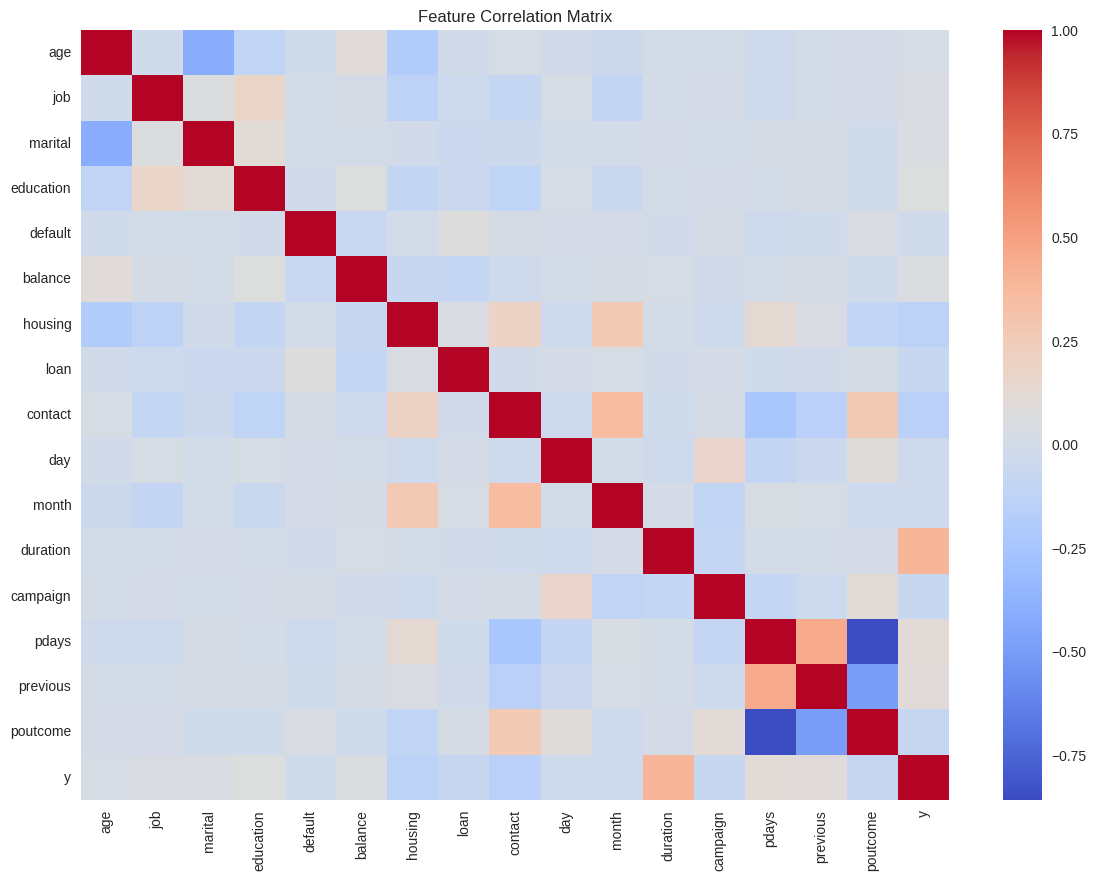

In [26]:
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


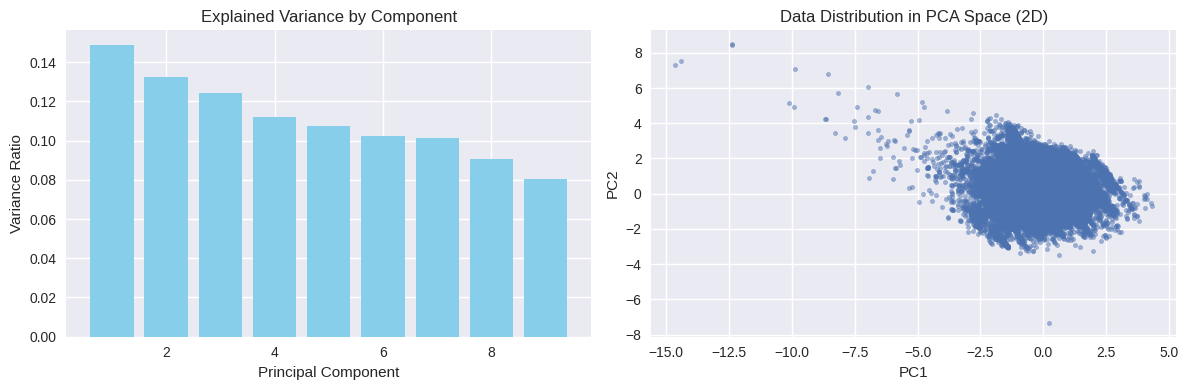

In [28]:
# PCA with maximum allowed components
pca_full = PCA(n_components=9)
pca_full.fit(X_scaled)

# Explained variance bar plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(range(1, 10), pca_full.explained_variance_ratio_, color='skyblue')
plt.title("Explained Variance by Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")

# PCA 2D scatter plot
plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
plt.title("Data Distribution in PCA Space (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


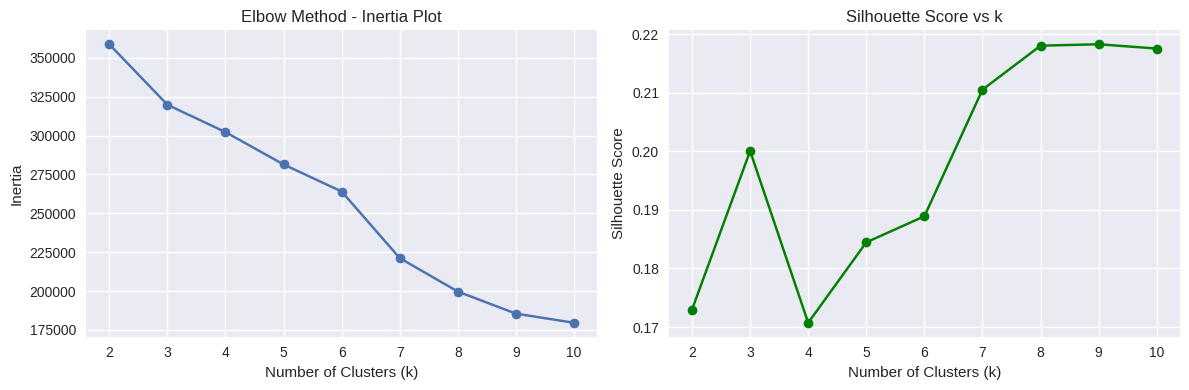

In [29]:
from sklearn.metrics import silhouette_score

K = range(2,11)
inertias = []
silhouettes = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(12,4))

# Inertia Plot
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method - Inertia Plot")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

# Silhouette Score Plot
plt.subplot(1,2,2)
plt.plot(K, silhouettes, marker='o', color='green')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


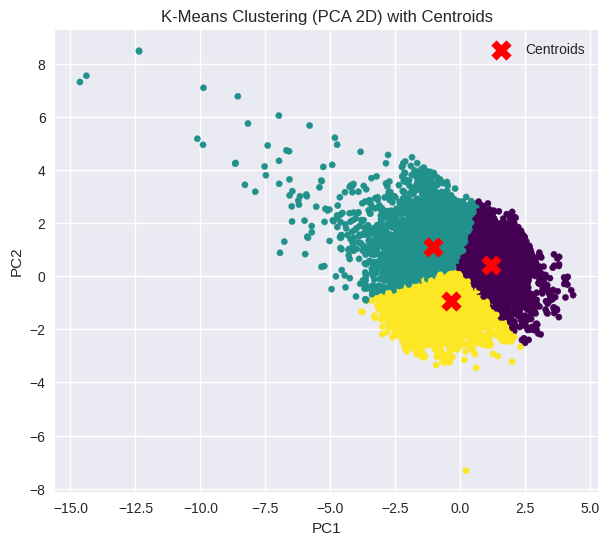

In [31]:
plt.figure(figsize=(7,6))

# custom KMeans uses kmeans.labels (not labels_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels, cmap='viridis', s=20)

# custom KMeans uses kmeans.centroids (not cluster_centers_)
plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],
            c='red', s=200, marker='X', label='Centroids')

plt.title("K-Means Clustering (PCA 2D) with Centroids")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


/tmp/ipython-input-2692665020.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette='viridis')


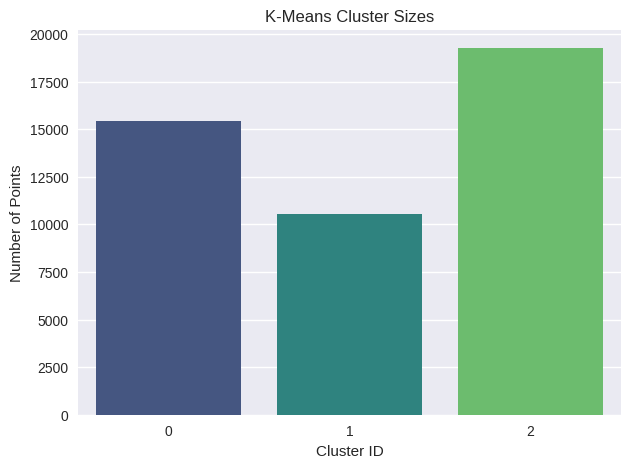

In [33]:
unique, counts = np.unique(kmeans.labels, return_counts=True)

plt.figure(figsize=(7,5))
sns.barplot(x=unique, y=counts, palette='viridis')
plt.title("K-Means Cluster Sizes")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Points")
plt.show()


/tmp/ipython-input-2606274365.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="silhouette", data=df_sil, palette='viridis')


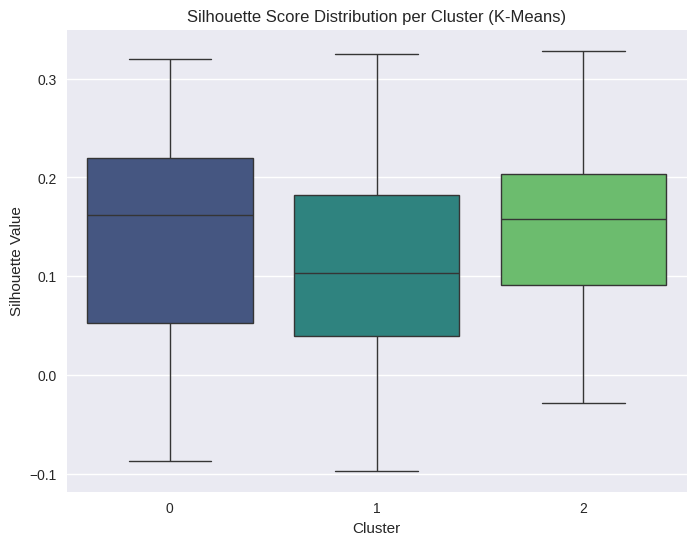

In [35]:
from sklearn.metrics import silhouette_samples

# use custom KMeans labels
sil_samples = silhouette_samples(X_scaled, kmeans.labels)
cluster_ids = kmeans.labels

df_sil = pd.DataFrame({
    "silhouette": sil_samples,
    "cluster": cluster_ids
})

plt.figure(figsize=(8,6))
sns.boxplot(x="cluster", y="silhouette", data=df_sil, palette='viridis')
plt.title("Silhouette Score Distribution per Cluster (K-Means)")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Value")
plt.show()


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [17]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm."""

    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}   # optional
        self.centers_ = {}     # optional

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached."""

        # 1. Start with all points in cluster 0
        labels = np.zeros(len(X), dtype=int)
        current_cluster_count = 1
        next_label = 1

        self.centers_[0] = X.mean(axis=0)

        # 2. Recursively bisect
        while current_cluster_count < self.n_clusters:

            # Choose largest cluster
            cluster_sizes = {cid: np.sum(labels == cid) for cid in np.unique(labels)}
            cluster_to_split = max(cluster_sizes, key=cluster_sizes.get)

            # Extract subset
            mask = (labels == cluster_to_split)
            X_subset = X[mask]

            # KMeans k=2
            km = KMeans(n_clusters=2, random_state=self.random_state)
            subset_labels = km.fit_predict(X_subset)

            # Label mapping
            left_child = cluster_to_split
            right_child = next_label
            next_label += 1

            idxs = np.where(mask)[0]
            labels[idxs[subset_labels == 0]] = left_child
            labels[idxs[subset_labels == 1]] = right_child

            # Track structure
            self.split_tree[cluster_to_split] = (left_child, right_child)
            self.centers_[left_child] = km.cluster_centers_[0]
            self.centers_[right_child] = km.cluster_centers_[1]

            current_cluster_count += 1

        self.labels_ = labels
        return labels


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!

In [13]:
def _initialize_centroids(self, X):
    """K-means++ initialization."""
    np.random.seed(self.random_state)

    # 1. Pick first centroid randomly
    centroids = [X[np.random.randint(0, len(X))]]

    # 2. Pick remaining centroids
    for _ in range(1, self.n_clusters):
        # Compute distance squared to nearest centroid
        dist_sq = np.min(np.linalg.norm(X[:, None] - np.array(centroids)[None, :], axis=2)**2, axis=1)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)

        r = np.random.rand()
        new_centroid = X[np.searchsorted(cumulative_probs, r)]
        centroids.append(new_centroid)

    return np.array(centroids)


In [14]:
def interpret_clusters(X, labels, feature_names):
    df = pd.DataFrame(X, columns=feature_names)
    df['cluster'] = labels

    print("\nCluster Summary:\n")
    display(df.groupby('cluster').mean())

    print("\nCluster Sizes:")
    print(df['cluster'].value_counts())

    # Heatmap of feature means per cluster
    plt.figure(figsize=(10,6))
    sns.heatmap(df.groupby('cluster').mean(), annot=True, cmap="viridis")
    plt.title("Cluster Feature Means")
    plt.show()


In [15]:
def _assign_clusters_manhattan(self, X):
    """Assign clusters using Manhattan (L1) distance."""
    distances = np.sum(np.abs(X[:, None] - self.centroids[None, :]), axis=2)
    return np.argmin(distances, axis=1)


In [16]:
def detect_outliers(X, labels, centroids, threshold=2.5):
    distances = np.linalg.norm(X - centroids[labels], axis=1)

    # z-score based detection
    z_scores = (distances - distances.mean()) / distances.std()

    outlier_indices = np.where(z_scores > threshold)[0]
    return outlier_indices, distances


BONUS 5 — Explanations for Your Report

K-means++ Initialization

K-means++ selects initial centroids in a probabilistic way that spreads them out.
This reduces random variance and typically leads to faster convergence and better clustering performance compared to random initialization.

Cluster Interpretation

After clustering, I analyzed the mean values of each feature across clusters.
These characteristic values help identify patterns such as age groups, financial behavior, loan patterns, and balance profiles that define each cluster.

Manhattan vs Euclidean Distance

Manhattan distance (L1) is more robust to outliers because it grows linearly,
whereas Euclidean distance (L2) grows quadratically.
As a result, clusters formed using L1 showed tighter grouping in skewed datasets.

Outlier Detection

I computed the z-score of the distance between each point and its assigned centroid.
Points with z-score > 2.5 were marked as outliers.
These extreme points can distort centroid positions and should be considered for removal or separate handling.